In [19]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [20]:
"""
Let's perform the camera calibration.
The goal of the camera calibration is to determine the camera's 
- intrinsic parameters (focal length, principal point, and lens distortion coefficients) and 
- extrinsic parameters (rotation and translation vectors).

What we need:
- a chessboard pattern
- chessboard pattern allows us :
    * to determine the points in the world coordinate system (we can assume a coordinate system at the first corner of the chessboard and 
    assume that the chessboard is flat and lies on the x-y plane (so z=0). This allows to build a grid of points in the world coordinate system.
    * to determine the points in the image sensor (pixel coordinates). This can be found from estimating the corners from the image.

"""

"\nLet's perform the camera calibration.\nThe goal of the camera calibration is to determine the camera's \n- intrinsic parameters (focal length, principal point, and lens distortion coefficients) and \n- extrinsic parameters (rotation and translation vectors).\n\nWhat we need:\n- a chessboard pattern\n- chessboard pattern allows us :\n    * to determine the points in the world coordinate system (we can assume a coordinate system at the first corner of the chessboard and \n    assume that the chessboard is flat and lies on the x-y plane (so z=0). This allows to build a grid of points in the world coordinate system.\n    * to determine the points in the image sensor (pixel coordinates). This can be found from estimating the corners from the image.\n\n"

(480, 640, 3)


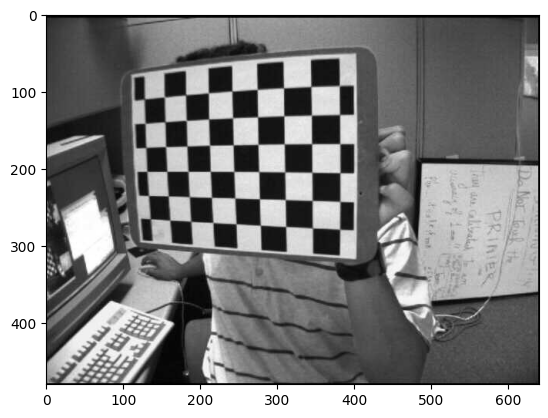

In [21]:
# Inspect our images
image_path = "./calibration/right01.jpg"
image = cv2.imread(image_path)
print(image.shape)
plt.imshow(image)
plt.show()

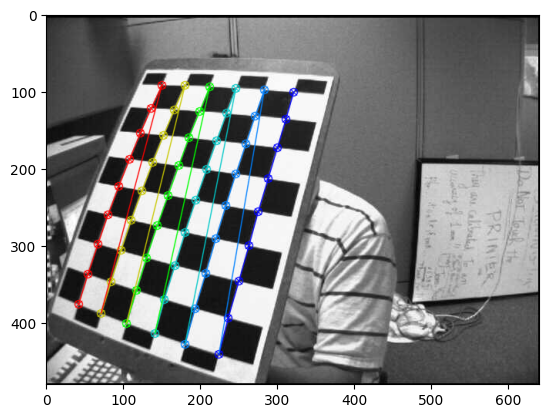

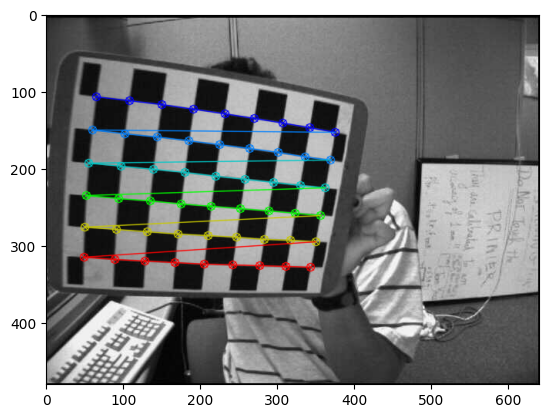

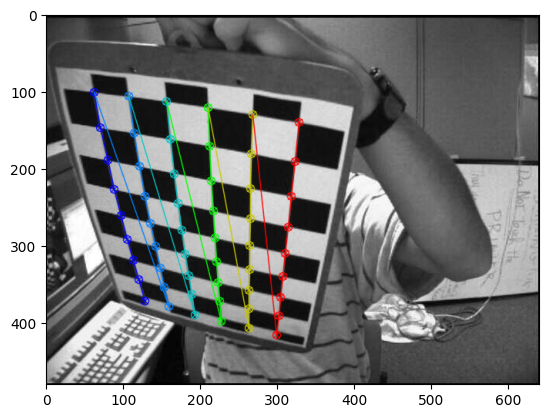

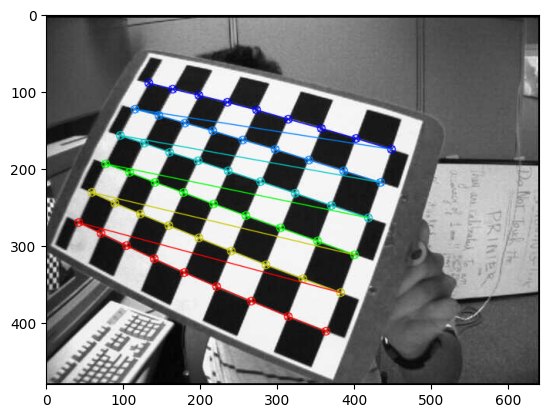

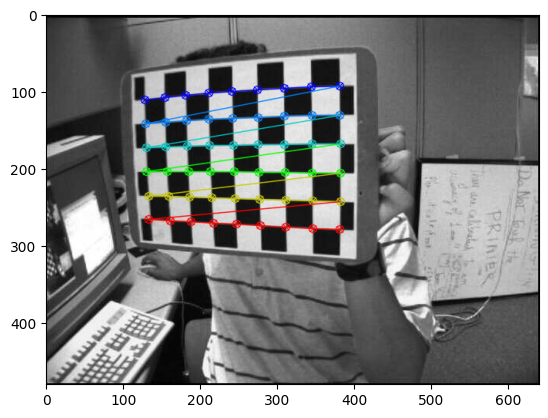

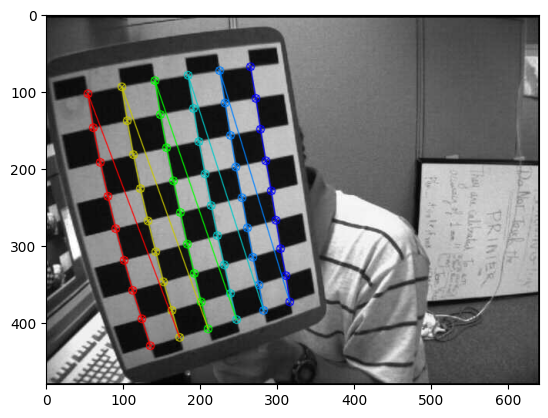

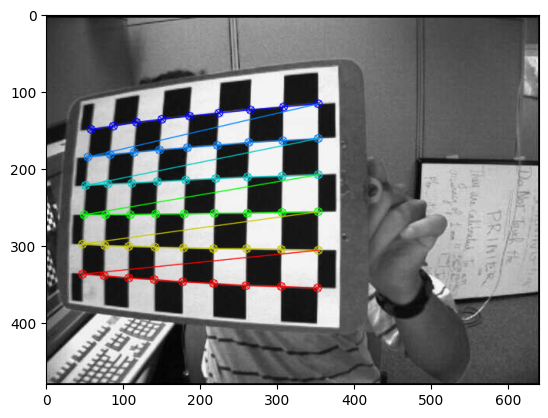

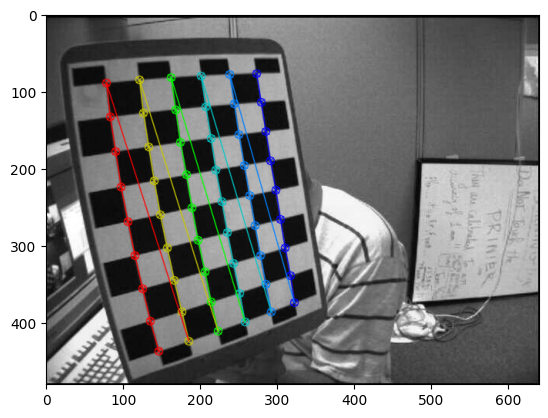

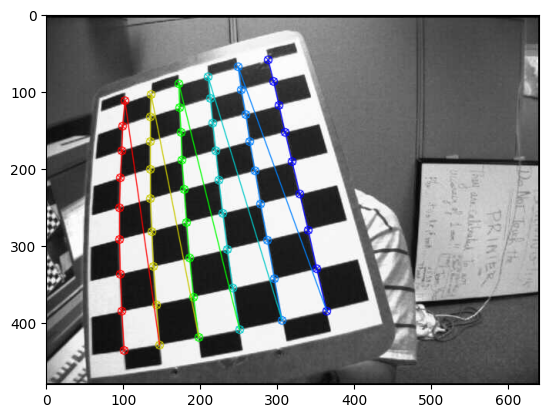

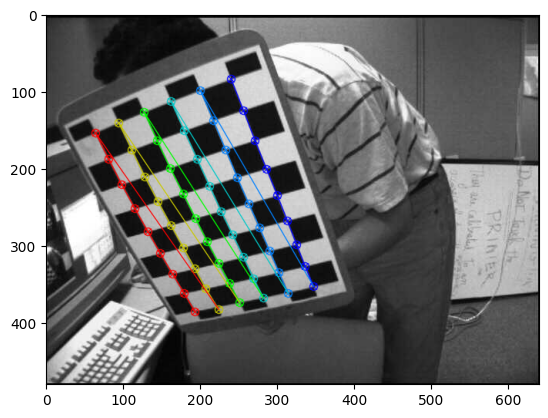

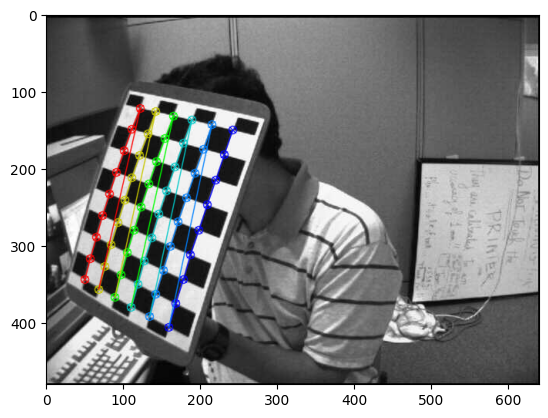

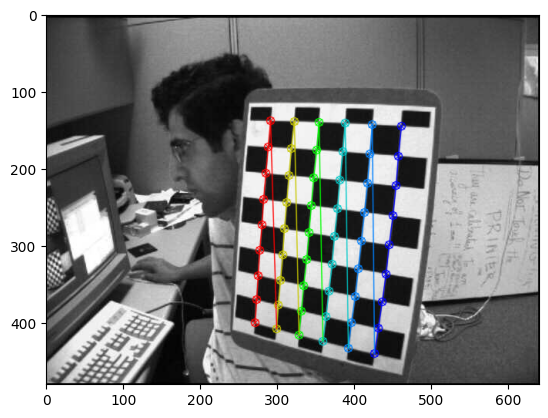

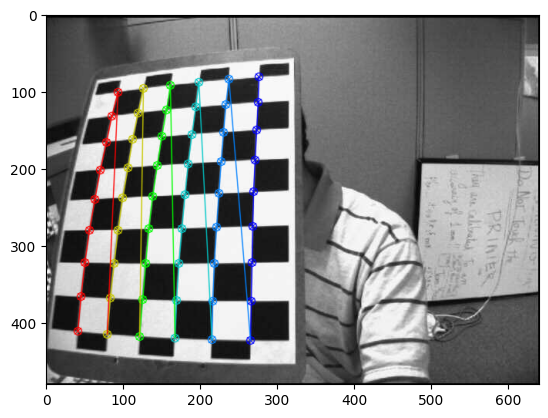

In [22]:
# Define the dimensions of the chessboard grid (9x6 in this case)
grid_dimensions = (9, 6)

# Set termination criteria for cornerSubPix
# Termination criteria for cornerSubPix refinement:
# - TERM_CRITERIA_EPS + TERM_CRITERIA_MAX_ITER: Stop when max iterations OR epsilon reached
# - 30: Maximum number of iterations
# - 0.001: Minimum change in coordinates (epsilon)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Create a 3D array of zeros representing the world coordinates of the chessboard corners
objp = np.zeros(
    (grid_dimensions[0] * grid_dimensions[1], 3), np.float32
)  # 3D array of zeros shape: (number of corners, 3)

# Create a grid of (x,y) coordinates for each chessboard corner
# np.mgrid creates coordinate matrices for each dimension (x and y)
# The .T transposes to get (x,y) pairs and reshape(-1,2) flattens to a list of points
# This assigns the x,y coordinates to the first two columns of objp, keeping z=0
# Each point represents a corner's position in the world coordinate system
objp[:, :2] = np.mgrid[0 : grid_dimensions[0], 0 : grid_dimensions[1]].T.reshape(-1, 2)

"""
We dont know the square size so we assume it to be 1 (some unit length).
The coordinate system is in the top left corner of the chessboard.
We assume that the chessboard is flat and lies on the x-y plane (so z=0).

"""
world_coordinate_points = []
image_plane_points = []

# Flag to control whether to plot the detected corners
plot = True

# Iterate through all jpg images in the calibration folder
for image_path in glob.glob("./calibration/*.jpg"):
    # Read the image and convert it to grayscale
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    # alternative: cv.findCirclesGrid()
    ret, corners = cv2.findChessboardCorners(gray, grid_dimensions, None)

    if ret:  # If corners are found
        world_coordinate_points.append(objp)

        # Refine the corner locations
        # Sometimes we need more accuracy that the camera can give us
        # https://upload.wikimedia.org/wikipedia/commons/5/52/SubpixelCircleint.png
        """
        Subpixel accuracy in images refers to the ability to measure or detect 
        features with a precision finer than the pixel grid. 
        This is achieved by analyzing the intensity values of pixels 
        and interpolating between them to estimate the exact location of a feature with greater accuracy.
        """
        # Refine corner locations to sub-pixel accuracy
        # gray: Input grayscale image
        # corners: Initial corner locations found by findChessboardCorners
        # (11,11): Size of search window for corner refinement - must be odd. Larger window = more accurate but slower
        # (-1,-1): Dead region in middle of search window - (-1,-1) means no dead region
        # criteria: Termination criteria for iterative refinement process
        corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

        # Add the refined corner locations to the list
        image_plane_points.append(corners)

        if plot:
            # If plot is True, draw and display the corners
            cv2.drawChessboardCorners(image, grid_dimensions, corners, ret)
            plt.imshow(image)
            plt.show()

In [23]:
# Calibrate the camera to find intrinsic and extrinsic parameters
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    world_coordinate_points,  # 3D points in real world space
    image_plane_points,  # 2D points in image plane
    gray.shape[::-1],  # Image size (width, height) - reversed since shape gives (h,w)
    None,  # Initial camera matrix (None = compute from scratch)
    None,  # Initial distortion coefficients (None = compute from scratch)
)
# ret: RMS re-projection error
# mtx: Camera matrix (intrinsic parameters)
# dist: Distortion coefficients
# rvecs: Rotation vectors for each image
# tvecs: Translation vectors for each image
# mtx is the camera matrix
print("Camera Matrix:")
print(gray.shape)
print(mtx)
"""
These values suggest that the camera has almost uniform scaling in both x and y directions, indicating a square pixel grid.
This principal point is close to the center of the image, which is typical for a well-calibrated camera.
Ox, Oy represent the principal point, or the point where the optical axis intersects the image plane.
"""
print(
    "Distortion Coefficients:"
)  # k1, k2, p1, p2, k3 - radial and tangential distortion coefficients
# k1, k2, k3: Radial distortion coefficients that model barrel/pincushion distortion
# p1, p2: Tangential distortion coefficients that model lens misalignment
print(dist)
# 13 images were used for calibration
print("Rotation Vectors:")
print(len(rvecs))
print("Translation Vectors:")
print(len(rvecs))

Camera Matrix:
(459, 612)
[[542.35493242   0.         328.32422303]
 [  0.         541.61515666 246.94734198]
 [  0.           0.           1.        ]]
Distortion Coefficients:
[[-0.28054252  0.10432055 -0.00055818  0.00130358 -0.02371789]]
Rotation Vectors:
13
Translation Vectors:
13


In [24]:
def calculate_extrinsic_matrix(rvec, tvec):
    """
    Calculate the extrinsic matrix from rotation vector and translation vector.

    The rotation vector (rvec) is converted to a rotation matrix using Rodrigues' formula.
    Rodrigues' formula provides a way to convert between axis-angle representation
    (rotation vector) and rotation matrix representation. The rotation vector represents
    rotation around an axis where the vector's direction is the axis and its magnitude
    is the angle in radians.

    :param rvec: Rotation vector (3x1) in axis-angle representation
    :param tvec: Translation vector (3x1)
    :returns: 4x4 homogeneous transformation matrix combining rotation and translation
    """
    R, _ = cv2.Rodrigues(rvec)  # Convert rotation vector to 3x3 rotation matrix
    E = np.hstack((R, tvec))  # Combine rotation matrix and translation vector
    return np.vstack((E, np.array([0, 0, 0, 1])))  # Add homogeneous row


def project_image_to_world(image_point, mtx_inv, E_inv):
    image_point = np.concatenate((image_point[0], [1]))
    camera_point = np.dot(mtx_inv, image_point)
    camera_point = np.concatenate((camera_point, [1]))
    return np.dot(E_inv, camera_point)[:3]


# This code performs back-projection from image coordinates to world coordinates
# The process follows these steps:
#
# 1. Image to Camera coordinates:
#    [x_c]   [fx  0  cx]-1   [u]
#    [y_c] = [0   fy cy]   * [v]
#    [z_c]   [0   0   1]     [1]
#    where (u,v) are image coordinates and (x_c,y_c,z_c) are camera coordinates
#
# 2. Camera to World coordinates:
#    [X]   [R | t]-1   [x_c]
#    [Y] = [     ]   * [y_c]
#    [Z]   [0 | 1]     [z_c]
#    [1]               [ 1 ]
#    where R is rotation matrix, t is translation vector

proj_points = []  # Will store world coordinates for each image
mtx_inv = np.linalg.inv(mtx)  # Inverse of camera intrinsic matrix

for rvec, tvec, image_points in zip(rvecs, tvecs, image_plane_points):
    # Get extrinsic matrix (camera pose) for this image
    E = calculate_extrinsic_matrix(rvec, tvec)

    # Get inverse of extrinsic matrix for back-projection
    E_inv = np.linalg.inv(E)
    
    # Back-project each point from image to world coordinates
    world_points = [
        project_image_to_world(point, mtx_inv, E_inv) for point in image_points
    ]
    proj_points.append(np.array(world_points))

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from ipywidgets import interactive
import ipywidgets as widgets

colors = {i: np.random.rand(3) for i in range(len(proj_points))}


def plot_3d_scene(azimuth, elevation):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")

    chessboard_points = world_coordinate_points[0]
    max_x = np.max(chessboard_points[:, 0])
    min_x = np.min(chessboard_points[:, 0])
    max_y = np.max(chessboard_points[:, 1])
    min_y = np.min(chessboard_points[:, 1])
    vertices = [
        [min_x, min_y, 0],
        [max_x, min_y, 0],
        [max_x, max_y, 0],
        [min_x, max_y, 0],
    ]
    rect = Poly3DCollection([vertices], color="red", alpha=0.2)
    ax.add_collection3d(rect)

    # draw the world coordinate axes with arrows
    ax.quiver(0, 0, 0, 5, 0, 0, color="red", arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, 0, 5, 0, color="green", arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, 0, 0, 5, color="blue", arrow_length_ratio=0.1)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # name (0,0,0)
    ax.text(0, 0, 0, "World Coordinate Frame", color="black")

    num_images = len(proj_points)
    for sample_idx in range(num_images):
        original_points_3d = world_coordinate_points[sample_idx]
        projected_points_3d = proj_points[sample_idx]

        for original_point, projected_point in zip(
            original_points_3d, projected_points_3d
        ):
            ax.plot(
                [original_point[0], projected_point[0]],
                [original_point[1], projected_point[1]],
                [original_point[2], projected_point[2]],
                color=colors[sample_idx],
                alpha=0.5,
            )

    # set equal aspect ratio
    ax.set_aspect("equal")
    # remove numbers on the axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    # Set the viewing angle
    ax.view_init(elev=elevation, azim=azimuth)

    plt.show()


# Create interactive plot
interactive_plot = interactive(
    plot_3d_scene,
    azimuth=widgets.FloatSlider(
        min=-180, max=180, step=1, value=0, description="Azimuth:"
    ),
    elevation=widgets.FloatSlider(
        min=-90, max=90, step=1, value=30, description="Elevation:"
    ),
)

display(interactive_plot)

interactive(children=(FloatSlider(value=0.0, description='Azimuth:', max=180.0, min=-180.0, step=1.0), FloatSl…

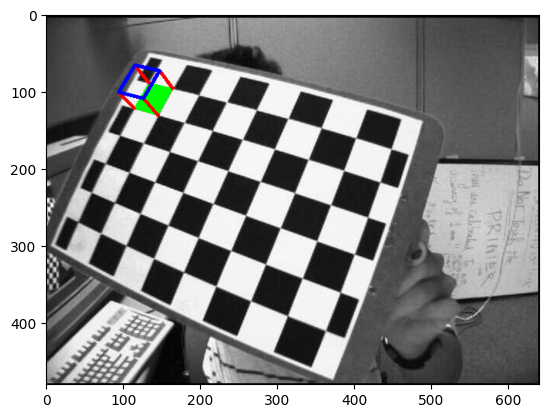

In [26]:
def draw(img, imgpts):
    imgpts = np.int32(imgpts).reshape(-1, 2)

    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]], -1, (0, 255, 0), -3)

    # draw pillars in blue color
    for i, j in zip(range(4), range(4, 8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]), (255), 3)

    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]], -1, (0, 0, 255), 3)

    return img


img = cv2.imread("./calibration/right03.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, grid_dimensions, None)
axis = np.float32(
    [
        [0, 0, 0],
        [0, 1, 0],
        [1, 1, 0],
        [1, 0, 0],
        [0, 0, -1],
        [0, 1, -1],
        [1, 1, -1],
        [1, 0, -1],
    ]
)
if ret:
    corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
    # Project 3D points to 2D image plane
    # axis: 3D points in world coordinates
    # rvecs[2]: rotation vector for this image
    # tvecs[2]: translation vector for this image
    # mtx: camera matrix with intrinsic parameters
    # dist: distortion coefficients
    # Returns:
    # imgpts: projected 2D points
    # jac: Jacobian matrix (not used here)
    imgpts, jac = cv2.projectPoints(axis, rvecs[3], tvecs[3], mtx, dist)
    img = draw(img, imgpts)
    plt.imshow(img)
    plt.show()